# Imports

In [20]:
%matplotlib inline
#from sensible_raw.loaders import loader
from collections import defaultdict
import calendar
import pandas as pd
import numpy as np
import pystan
import matplotlib.pylab as plt
import json
import bandicoot_dev as bc_d
from datetime import datetime as dt
from scipy.stats.mstats import zscore
from collections import Counter

# Utility functions

In [6]:
def default_to_regular(d):
    """Recursively convert nested defaultdicts to nested dicts.

    Source: http://stackoverflow.com/questions/26496831/how-to-convert-defaultdict-of-defaultdicts-of-defaultdicts-to-dict-of-dicts-o
    """
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.iteritems()}
    return d

def invert_partition(partition):
    if type(partition.items()[0][1]) is list:
        partition_inv = dict()
        for c, nodes in partition.items():
            for n in nodes:
                partition_inv[n] = c
    else:
        partition_inv = defaultdict(list)
        for n, c in partition.items():
            partition_inv[c].append(n)
    return default_to_regular(partition_inv)

def load_data(kind, period):
    columns, data = loader.load_data(kind, period)
    return pd.DataFrame(dict((column, array) for column, array in zip(columns, data)))

# Get data (remote only)

**Get vector groups**

In [ ]:
dataframe_vectors = load_data("vectors", "vectors")
student_vector_group = dict((k, v) for k, v in zip(dataframe_vectors['user'], dataframe_vectors['vector']) if v > 0 and k < 10000)
vector_group_students = invert_partition(student_vector_group)

# Filter groups with less than 3 members
vector_group_students = dict((k, v) for k, v in vector_group_students.items() if len(v) >= 3)

**Get features**

In [62]:
tc = "tc0"

def cl(f):
    return '_'.join(('_'.join(f.split("__allweek__allday__"))).split("__"))

class SufficiencyException(Exception):
    pass

def compute_features(userid, tc, groupby="week", summary="special"):
    
    def _threshold_test(user):
        def __recs_per_day(records):
            counter = len(records) * 1.0
            span = (max(records, key=lambda r: r.datetime).datetime - \
                    min(records, key=lambda r: r.datetime).datetime).days
            if span == 0:
                return 0
            return counter/span

        thresholds = [
            (user.text_records, 2),
            (user.call_records, 1),
            (user.physical_records, 1),
            (user.screen_records, 20),
            (user.stop_records, 1)
        ]

        for records, thr in thresholds:
            if __recs_per_day(records) < thr:
                return False
        return True
    
    user = bc_d.read_csv(
        "%d" % userid, 
        call_path="data_cache/records/call/%s/" % tc,
        text_path="data_cache/records/text/%s/" % tc,
        physical_path="data_cache/records/physical/%s/" % tc,
        screen_path="data_cache/records/screen/%s/" % tc,
        stop_path="data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )

    if not _threshold_test(user):
        raise SufficiencyException("User '%s' has too few records for analysis" % str(userid))
    
    user.start_time['any'] = dt.strptime('01/01/14', "%d/%m/%y")
    user.end_time['any'] = dt.strptime('01/01/15', "%d/%m/%y")
    
    indicators = bc_d.utils.all(
        user,
        groupby=groupby,
        summary=summary,
        dist=True,
        network=False,
        spatial=False
    )

    for ex in ['name', 'reporting']:
        del indicators[ex]

    return bc_d.utils.flatten(indicators), user

In [ ]:
student_data_tc0 = dict()
u_prev = 0
for u, _ in student_vector_group.items():
    if u < u_prev: continue
    try:
        ds, _ = compute_features(u, tc=tc, groupby='week', summary='special')
        student_data_tc0[u] = dict((cl(k), filter(lambda f: f is not None, v)) for k, v in ds.items()) 
        print u
    except ValueError as e:
        print u, "failed"
    except SufficiencyException as e:
        print e
    except ZeroDivisionError as e:
        print u, e
        
    u_prev = u

**Get vector group features**

In [134]:
vector_group_features = defaultdict(lambda: defaultdict(list))
for u, data in student_data_tc0.items():
    for f, d in data.items():
        if d == []:
            continue
        if type(d[0]) is dict:
            d = [_d['mean'] for _d in d if _d['mean'] is not None]
        vector_group_features[student_vector_group[u]][f].append(np.mean(d))

vector_group_features = dict(
    (gid, data)
    for gid, data in vector_group_features.items()
    if np.ceil(np.mean(map(len, data.values()))) >= 3
)

**Get individual predictors**

In [200]:
def summarize(data):
    data_out = {}
    for f, d in data.items():
        if d == []:
            continue
        if type(d[0]) is dict:
            d = [_d['mean'] for _d in d if _d['mean'] is not None]
        data_out[f] = np.mean(d)
    return data_out

student_data_summary = dict(
    (u, summarize(data))
    for u, data in student_data_tc0.items()
    if student_vector_group[u] in vector_group_features
)

feature_labels = sorted(data.keys())

**Get grades**

In [179]:
dataframe_grades = load_data("grades", "january_2014")
student_grades = defaultdict(list)
for u, g in zip(dataframe_grades['user'], dataframe_grades['grade']):
    if g in ["EM", "BE", "IB", "V", "SN", "S"]: continue
    student_grades[u].append(int(g))

**Get individual feaures and outcomes**

In [209]:
x, y, nn, jj = [], [], [], []
for u, data in student_data_summary.items():
    gpa = np.mean(student_grades[u])
    if np.isnan(gpa):
        print u, "has no grades"
        
    x.append([data[f] if f in data else 0 for f in feature_labels])
    y.append(gpa)
    nn.append(u)
    jj.append(student_vector_group[u])

21 has no grades
31 has no grades
59 has no grades
66 has no grades
129 has no grades
143 has no grades
202 has no grades
346 has no grades


In [211]:
group_map = dict(zip(set(jj), range(len(set(jj)))))
jj = [group_map[j] for j in jj]

**Save (only able on remote server)**

In [213]:
with open("data/jj.json", 'w') as fp:
    json.dump(jj, fp)
with open("data/y.json", 'w') as fp:
    json.dump(y, fp)
with open("data/x.json", 'w') as fp:
    json.dump(x, fp)
with open("data/feature_labels.json", 'w') as fp:
    json.dump(feature_labels, fp)

# Load data (local only)

In [7]:
with open("data/jj.json", 'r') as fp:
    jj = np.array(json.load(fp)) + 1
with open("data/y.json", 'r') as fp:
    y = np.array(json.load(fp))
with open("data/x.json", 'r') as fp:
    x = np.array(json.load(fp))
with open("data/feature_labels.json", 'r') as fp:
    feature_labels = json.load(fp)

In [35]:
x_f, y_f, jj_f  = [], [], []
for _x, _y, _jj in zip(x, y, jj):
    if np.isnan(_y): continue
    x_f.append(_x.tolist())
    y_f.append(_y)
    jj_f.append(_jj)

x_f = zscore(np.nan_to_num(x_f))

# Analysis

## Simple hierarchical model

In [9]:
# USING: ==== Hierarchical prior for means and variances in comparison of K groups ====
code = """
data {
    int<lower=0> N; // number of data points 
    int<lower=0> K; // number of groups 
    int<lower=1,upper=K> x[N]; // group indicator 
    vector[N] y; // 
}
parameters {
    real mu0;             // hyper-prior mean 
    real<lower=0> sigma0; // hyper-prior std 
    vector[K] mu;         // group means 
    real<lower=0> sigma;  // common std 
}
model {
    mu0 ~ normal(mean(y), sd(y));      // weakly informative prior. NOTE: Here I use the empirical mean and SD of the data as hyper-prior parameters.
    sigma0 ~ normal(7, 4);          // weakly informative prior. NOTE: Here I have computed the mean and SD of the in-class SDs and used them as hyper-prior parameters.
    mu ~ normal(mu0, sigma0);          // population prior with unknown parameters.
    for (n in 1:N)
      y[n] ~ normal(mu[x[n]], sigma);
}
generated quantities {
    real y6_pred;
    y6_pred = normal_rng(mu[x[6]], sigma);
}
"""

data = dict(
    N = len(y_f),
    K = len(set(jj_f)),
    x = list(jj_f),
    y = y_f
)
# Compile and fit the model
fit = pystan.stan(model_code=code, data=data)

# Extract samples
samples = fit.extract(permuted=True)

Matrix of probabilities that one mu is larger than other:
[[ 0.       0.44625  0.35525]
 [ 0.55375  0.       0.40175]
 [ 0.64475  0.59825  0.     ]]


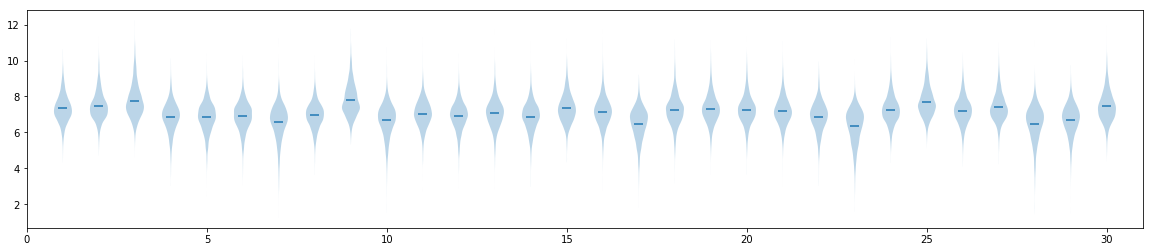

In [10]:
mu = samples['mu']
# Matrix of probabilities that one mu is larger than other
ps = np.zeros((3,3))
for k1 in range(3):
    for k2 in range(k1+1,3):
        ps[k1,k2] = np.mean(mu[:,k1]>mu[:,k2])
        ps[k2,k1] = 1 - ps[k1,k2]
print("Matrix of probabilities that one mu is larger than other:")
print(ps)
# Plot
plt.figure(None, (20, 4))
plt.violinplot(mu,showmeans=True,showextrema=False)
plt.xlim([0, 31])
plt.savefig("figures/violinplot.pdf")

## Hierarchical model regression

In [39]:
# USING: ==== Hierarchical prior for means and variances in comparison of K groups ====
code = """
data {
    int<lower=0> N; // num individuals
    int<lower=1> K; // num ind predictors
    int<lower=1> J; // num groups
    int<lower=1> L; // num group predictors
    int<lower=1,upper=J> jj[N]; // group for individual
    matrix[N, K] x; // individual predictors
    row_vector[L] u[J]; // group predictors
    vector[N] y; // outcomes
}
parameters {
    corr_matrix[K] Omega; // prior correlation
    vector<lower=0>[K] tau; // prior scale
    matrix[L, K] gamma; // group coeffs
    vector[K] beta[J]; // indiv coeffs by group
    real<lower=0> sigma; // prediction error scale
}
model {
    tau ~ cauchy(0, 1);
    Omega ~ lkj_corr(2);
    to_vector(gamma) ~ normal(0, 1);
    {
        row_vector[K] u_gamma[J];
        for (j in 1:J)
            u_gamma[j] = u[j] * gamma;
        beta ~ multi_normal(u_gamma, quad_form_diag(Omega, tau));
    }
    for (n in 1:N)
        y[n] ~ normal(x[n] * beta[jj[n]], sigma);
}
"""

data = dict(
    N = len(y_f),
    K = x_f.shape[1],
    J = len(set(jj_f)),
    y = y_f + min(y_f) + 0.01,
    L = 1,
    jj = jj_f,
    x = zscore(x_f),
    u = [[np.random.random()] for _ in range(len(set(jj_f)))]
)

# Compile and fit the model
fit = pystan.stan(model_code=code, data=data)

# Extract samples
samples = fit.extract(permuted=True)

RuntimeError: Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 27: multi_normal_log: LDLT_Factor of covariance parameter is not positive definite. last conditional variance is 8.63892e-16.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 27: multi_normal_log: LDLT_Factor of covariance parameter is not positive definite. last conditional variance is -6.93889e-18.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 21: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.



Initialization between (-2, 2) failed after 100 attempts. 
 Try specifying initial values, reducing ranges of constrained values, or reparameterizing the model.
